In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import matplotlib.patches as mpatches
import datetime
import gmplot
import matplotlib.colors as cl

In [332]:
def distance(longitude1,latitude1,longitude2,latitude2):
    
    #convert from decimal degrees to radians
    long1 = np.radians(longitude1)
    long2 = np.radians(longitude2)
    lati1 = np.radians(latitude1)
    lati2 = np.radians(latitude2)
    
    dlong = long2 - long1
    dlati = lati2 - lati1
    
    #haversine formula for a great circle distance
    a = np.square(np.sin(dlati/2))+np.multiply(np.multiply(np.cos(lati1),np.cos(lati2)),np.square(np.sin(dlong/2)))
    c = 2 * np.arcsin(np.sqrt(a))
    
    r = 3955.082 #earth's radius in miles at London (0 elevation)
    
    return c*r

In [50]:
#road class conversion of CYCLANDS 1st_Road_Class variable
road_classes = np.array(['','M','A(M)','A','B','C','U','na'])

##upper left, lower right corners of Greater London (lat,long)

#Dan's
# corners = [(51.68863717738605, -0.5468983269149709),(51.28157836053724, 0.3732066186882609)]

#Greg's
corners = [(51.543,-0.179),(51.475,0.023)]

In [136]:
#collision data from CYCLANDS
collisions = pd.read_csv('./uk_gov/cycling_safety_uk_gov.csv',parse_dates=['Date'])
collisions['Road_name'] = road_classes[collisions['1st_Road_Class'].values].astype(object)+collisions['1st_Road_Number'].apply(str).values
collisions.Road_name = collisions.Road_name.str.replace('U0','U')
collisions.Road_name = collisions.Road_name.str.replace('C0','C')
collisions['Road_name2'] = road_classes[collisions['2nd_Road_Class'].values].astype(object)+collisions['2nd_Road_Number'].apply(str).values
collisions.Road_name2 = collisions.Road_name2.str.replace('U0','U')
collisions.Road_name2 = collisions.Road_name2.str.replace('C0','C')

#annual average daily flow traffic data from https://roadtraffic.dft.gov.uk
aadf = pd.read_csv('./uk_gov/dft_traffic_counts_aadf.csv',low_memory=False,parse_dates=['Year'])

In [327]:
from sklearn.neighbors import NearestNeighbors

matches = 0
london_col = 0

for year in np.arange(2005,2019):
    
    #slice data on year and within Greater London
    aadf_year = aadf[(aadf.Year.dt.year == year) & (aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])].copy()
    collisions_year = collisions[(collisions.Date.dt.year == year) & (collisions.Longitude > corners[0][1]) & (collisions.Longitude < corners[1][1]) & (collisions.Latitude > corners[1][0]) & (collisions.Latitude < corners[0][0])].copy()
    
    #count collisions in London
    london_col += len(collisions_year)
    
    #Create Road name variable that matches aadf
    #collisions_year['Road_name'] = road_classes[collisions_year['1st_Road_Class'].values].astype(object)+collisions_year['1st_Road_Number'].apply(str).values
    
    #find nearest aadf cp neighbor to collisions
    neigh = NearestNeighbors(n_neighbors=1,radius=0.1)
    neigh.fit(aadf_year[['Longitude','Latitude']])
    A,B = neigh.kneighbors(collisions_year[['Longitude','Latitude']],1)
    
    #count correct geomatches
    matches += np.sum(aadf_year.iloc[B.flatten().tolist()].Road_name.values == collisions_year.Road_name.values)
    
    A_match = A[aadf_year.iloc[B.flatten().tolist()].Road_name.values == collisions_year.Road_name.values]
    
    print(year)
    print('mean distance to CP:',A_match.mean()*61.8)
    print('median distance to CP:',np.median(A_match)*61.8)
    print('max distance to CP:',A_match.max()*61.8)
    print('min distance to CP:',A_match.min()*61.8)
    print('Correct geo match:',len(A_match))
    print('Total London collisions:',len(collisions_year))
    print('% matched:',len(A_match)/len(collisions_year))
    print()

print('total')
print('Correct geo match:',matches)
print('Total London collisions:',london_col)
print('% matched:',matches/london_col)

2005
mean distance to CP: 0.08802650674194297
median distance to CP: 0.06518540058274697
max distance to CP: 0.420734100424044
min distance to CP: 0.0025005235440245023
Correct geo match: 449
Total London collisions: 978
% matched: 0.4591002044989775

2006
mean distance to CP: 0.0929351893041538
median distance to CP: 0.06586925060628641
max distance to CP: 0.6171844096822772
min distance to CP: 0.0025709668155781402
Correct geo match: 510
Total London collisions: 1088
% matched: 0.46875

2007
mean distance to CP: 0.09729826700707805
median distance to CP: 0.0672322823503299
max distance to CP: 0.574799588421124
min distance to CP: 0.002571929174308482
Correct geo match: 540
Total London collisions: 1099
% matched: 0.4913557779799818

2008
mean distance to CP: 0.08702808284237493
median distance to CP: 0.064794455625575
max distance to CP: 0.5276425133499693
min distance to CP: 0.002573319643253185
Correct geo match: 604
Total London collisions: 1224
% matched: 0.4934640522875817

2009

Text(0.5, 1.0, '2018')

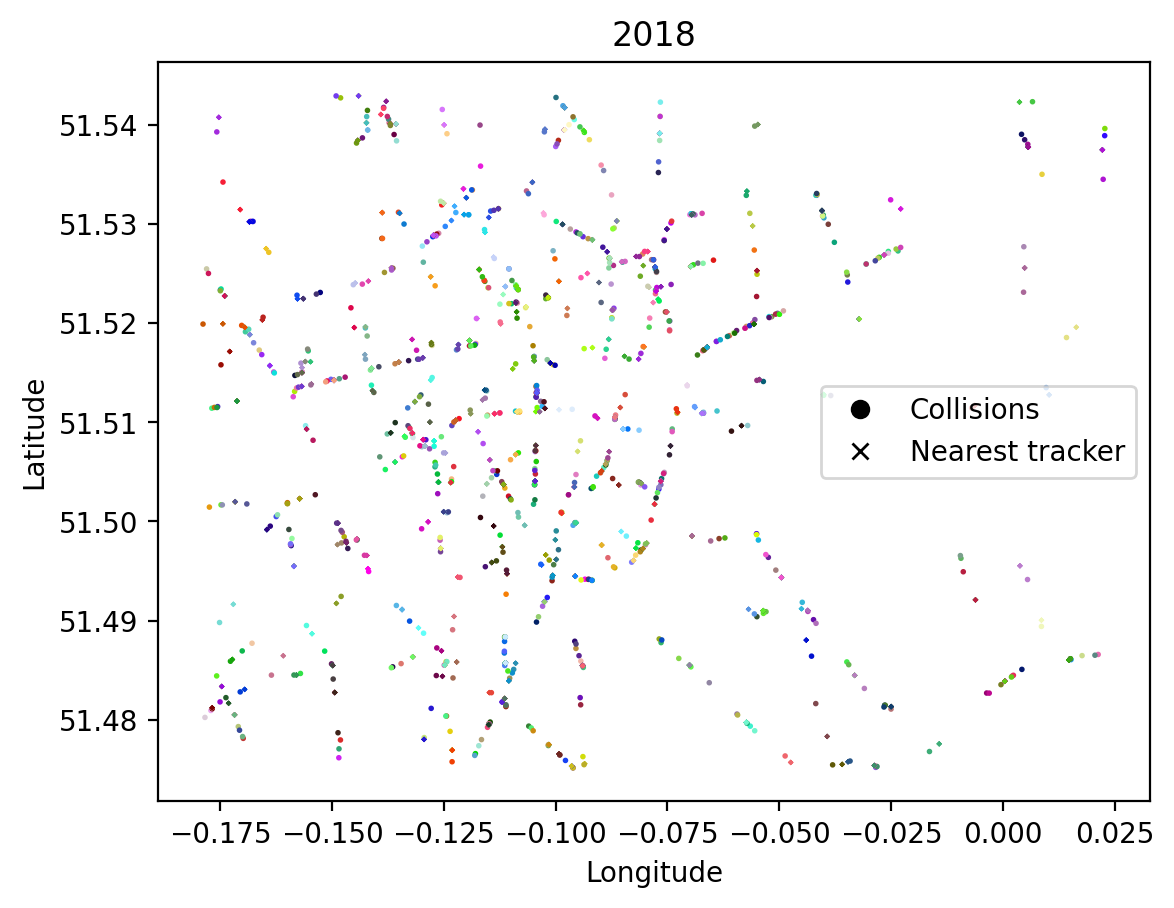

In [5]:
plotN = 700

colors = np.random.rand(plotN,3)

match_mask = aadf_year.iloc[B.flatten().tolist()].Road_name.values == collisions_year.Road_name.values

fig = plt.figure(dpi=200)
ax = fig.add_subplot(1,1,1)
ax.scatter(collisions_year.iloc[match_mask].head(plotN).Longitude,collisions_year.iloc[match_mask].head(plotN).Latitude,c=colors,s=1)
# for i,(txt,long,lat) in enumerate(zip(collisions_year.iloc[match_mask].head(plotN).Road_name.values,collisions_year.iloc[match_mask].head(plotN).Longitude.values,collisions_year.iloc[match_mask].head(plotN).Latitude.values)):
#     ax.annotate(txt, (long,lat),color='black')


ax.scatter(aadf_year.iloc[B[match_mask][:plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B[match_mask][:plotN].flatten().tolist()].Latitude.values,c=colors,marker='x',s=1)
# for i,(txt,long,lat) in enumerate(zip(aadf_year.iloc[B[match_mask][:plotN].flatten().tolist()].Road_name.values,aadf_year.iloc[B[match_mask][:plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B[match_mask][:plotN].flatten().tolist()].Latitude.values)):
#     ax.annotate(txt, (long,lat),color=colors[i])

#Get artists and labels for legend and chose which ones to display
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2)

#Create custom artists
simArtist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
anyArtist = plt.Line2D((0,1),(0,0), color='k',marker='x',linestyle='')

#Create legend from custom artist/label lists
plt.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist],
          [label for i,label in enumerate(labels) if i in display]+['Collisions', 'Nearest tracker'])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.xlim([-0.8,0.5])
#plt.ylim([51.2,51.8])
plt.title('2018')

## Examine nearest neighbors

In [75]:
year = 2018

aadf2018 = aadf[(aadf.Year.dt.year == year) & (aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])].copy()
collisions2018 = collisions[(collisions.Date.dt.year == year) & (collisions.Longitude > corners[0][1]) & (collisions.Longitude < corners[1][1]) & (collisions.Latitude > corners[1][0]) & (collisions.Latitude < corners[0][0])].copy()

In [76]:
from sklearn.neighbors import NearestNeighbors

In [77]:
neigh = NearestNeighbors(n_neighbors=1,radius=0.1)

In [78]:
neigh.fit(aadf2018[['Longitude','Latitude']])

NearestNeighbors(n_neighbors=1, radius=0.1)

In [79]:
A,B = neigh.kneighbors(collisions2018[['Longitude','Latitude']],10)

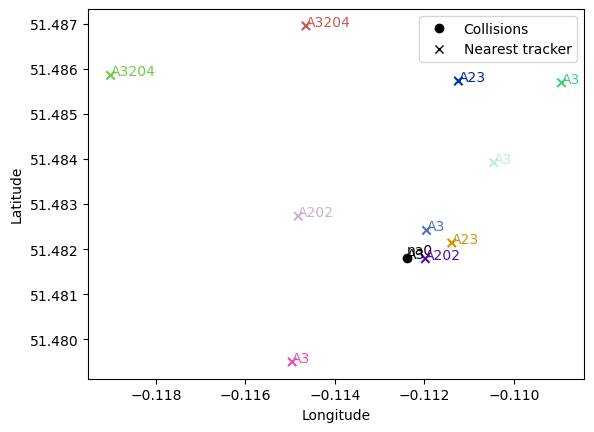

In [84]:
plotN = 20

colors = np.random.rand(10,3)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(collisions2018.iloc[plotN].Longitude,collisions2018.iloc[plotN].Latitude,c='black')
ax.annotate(road_classes[collisions2018.iloc[plotN]['1st_Road_Class']]+str(collisions2018.iloc[plotN]['1st_Road_Number']), (collisions2018.iloc[plotN].Longitude,collisions2018.iloc[plotN].Latitude),color='black')
# ax.annotate(road_classes[collisions2018.iloc[plotN]['2nd_Road_Class']]+str(collisions2018.iloc[plotN]['2nd_Road_Number']), (collisions2018.iloc[plotN].Longitude,collisions2018.iloc[plotN].Latitude+0.0001),color='black')

ax.scatter(aadf2018.iloc[B[plotN].flatten().tolist()].Longitude.values,aadf2018.iloc[B[plotN].flatten().tolist()].Latitude.values,c=colors,marker='x')
for i,(txt,long,lat) in enumerate(zip(aadf2018.iloc[B[plotN].flatten().tolist()].Road_name.values,aadf2018.iloc[B[plotN].flatten().tolist()].Longitude.values,aadf2018.iloc[B[plotN].flatten().tolist()].Latitude.values)):
    ax.annotate(txt, (long,lat),color=colors[i])

#Get artists and labels for legend and chose which ones to display
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2)

#Create custom artists
simArtist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
anyArtist = plt.Line2D((0,1),(0,0), color='k',marker='x',linestyle='')

#Create legend from custom artist/label lists
plt.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist],
          [label for i,label in enumerate(labels) if i in display]+['Collisions', 'Nearest tracker'])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.xlim([-0.8,0.5])
#plt.ylim([51.2,51.8])
plt.show()

In [49]:
aadf2018.iloc[B[plotN].flatten().tolist()].Road_name.values

array(['A200', 'A101', 'A2206', 'A2208', 'A2208', 'A2208', 'A2208', 'C',
       'A200', 'A200', 'U', 'A2208', 'A1203', 'A101', 'A200', 'U', 'A200',
       'A200', 'B207', 'A13'], dtype=object)

In [55]:
aadf2018.iloc[B[plotN].flatten().tolist()].Start_junction_road_name.values

array(['A101', 'A200', 'A100/A2205', 'A2206', 'Rotherhithe New Rd',
       'Hawkstone Rd', 'A2', nan, 'A2208', 'A2208', nan, 'A200', 'A1202',
       'LA Boundary', 'A2208', nan, 'A2208', 'B202', nan,
       'A11/A1202 mid-junction'], dtype=object)

In [174]:
aadf_year.iloc[B.flatten().tolist()].Road_name.values

array(['A4206', 'A4000', 'U', ..., 'A780', 'A701', 'A75'], dtype=object)

In [173]:
collisions_year.Road_name.values

16852

In [183]:
A[aadf_year.iloc[B.flatten().tolist()].Road_name.values == collisions_year.Road_name.values]

array([[0.00530392],
       [0.00040256],
       [0.00213593],
       ...,
       [0.0206665 ],
       [0.00153796],
       [0.00337566]])

In [195]:
len(collisions)

250963

## Check k>1 nearest neighbor for match

In [331]:
from sklearn.neighbors import NearestNeighbors

matches = 0
london_col = 0

for year in np.arange(2005,2019):
    
    #slice data on year and within Greater London
    aadf_year = aadf[(aadf.Year.dt.year == year) & (aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])].copy()
    collisions_year = collisions[(collisions.Date.dt.year == year) & (collisions.Longitude > corners[0][1]) & (collisions.Longitude < corners[1][1]) & (collisions.Latitude > corners[1][0]) & (collisions.Latitude < corners[0][0])].copy()
    
    #count collisions in London
    london_col += len(collisions_year)
    
    #Create Road name variable that matches aadf
    #collisions_year['Road_name'] = road_classes[collisions_year['1st_Road_Class'].values].astype(object)+collisions_year['1st_Road_Number'].apply(str).values
    
    #find nearest aadf cp neighbor to collisions
    neigh = NearestNeighbors(n_neighbors=1,radius=0.1)
    neigh.fit(aadf_year[['Longitude','Latitude']])
    A,B = neigh.kneighbors(collisions_year[['Longitude','Latitude']],10)
    
#     #count correct geomatches

    match_idx = np.zeros((len(B),10))
    
    for i in range(10):
        match_idx[aadf_year.iloc[B[:,i].flatten().tolist()].Road_name.values == collisions_year.Road_name.values,i] = 1
        
    invalid_val = -1
    mask = match_idx != 0
    check = np.where(mask.any(axis=1), mask.argmax(axis=1), invalid_val)
    
    match = np.where(check.astype(int) >= 0,True,False)
        
    matches += match.sum()
    
    A_match = A[np.arange(B.shape[0]),check][match]
    B_match = B[np.arange(B.shape[0]),check][match]
    
    print(year)
    print('mean distance to CP:',A_match.mean()*61.8)
    print('median distance to CP:',np.median(A_match)*61.8)
    print('max distance to CP:',A_match.max()*61.8)
    print('min distance to CP:',A_match.min()*61.8)
    print('Correct geo match:',len(A_match))
    print('Total London collisions:',len(collisions_year))
    print('% matched:',match.sum()/len(collisions_year))
    print()

print('total')
print('Correct geo match:',matches)
print('Total London collisions:',london_col)
print('% matched:',matches/london_col)

2005
mean distance to CP: 0.17627462734615512
median distance to CP: 0.11457217711549578
max distance to CP: 0.9860446028226402
min distance to CP: 0.0025005235440245023
Correct geo match: 765
Total London collisions: 978
% matched: 0.7822085889570553

2006
mean distance to CP: 0.1747820983459232
median distance to CP: 0.11530914770400645
max distance to CP: 1.1200963972068148
min distance to CP: 0.0025709668155781402
Correct geo match: 831
Total London collisions: 1088
% matched: 0.7637867647058824

2007
mean distance to CP: 0.17213151546224362
median distance to CP: 0.10919551009969403
max distance to CP: 1.1206225519118687
min distance to CP: 0.002571929174308482
Correct geo match: 873
Total London collisions: 1099
% matched: 0.7943585077343039

2008
mean distance to CP: 0.165025895926861
median distance to CP: 0.10817137095154236
max distance to CP: 0.9879614392388085
min distance to CP: 0.002573319643253185
Correct geo match: 1012
Total London collisions: 1224
% matched: 0.8267973

Text(0.5, 1.0, '2018')

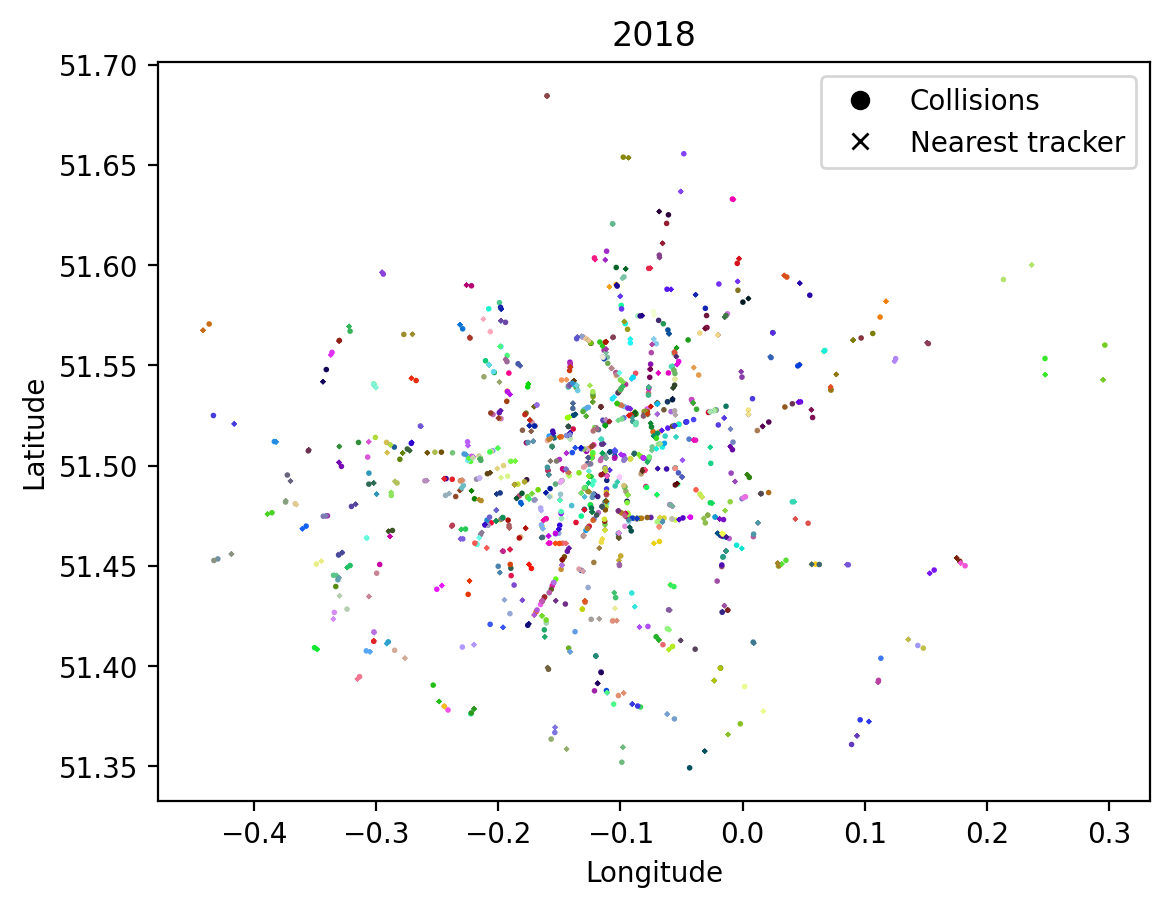

In [6]:
plotN = 700

colors = np.random.rand(plotN,3)

fig = plt.figure(dpi=200)
ax = fig.add_subplot(1,1,1)
ax.scatter(collisions_year.iloc[match].head(plotN).Longitude,collisions_year.iloc[match].head(plotN).Latitude,c=colors,s=1)
# for i,(txt,long,lat) in enumerate(zip(collisions_year.iloc[match_mask].head(plotN).Road_name.values,collisions_year.iloc[match_mask].head(plotN).Longitude.values,collisions_year.iloc[match_mask].head(plotN).Latitude.values)):
#     ax.annotate(txt, (long,lat),color='black')


ax.scatter(aadf_year.iloc[B_match[:plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B_match[:plotN].flatten().tolist()].Latitude.values,c=colors,marker='x',s=1)
# for i,(txt,long,lat) in enumerate(zip(aadf_year.iloc[B[match_mask][:plotN].flatten().tolist()].Road_name.values,aadf_year.iloc[B[match_mask][:plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B[match_mask][:plotN].flatten().tolist()].Latitude.values)):
#     ax.annotate(txt, (long,lat),color=colors[i])

#Get artists and labels for legend and chose which ones to display
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2)

#Create custom artists
simArtist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
anyArtist = plt.Line2D((0,1),(0,0), color='k',marker='x',linestyle='')

#Create legend from custom artist/label lists
plt.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist],
          [label for i,label in enumerate(labels) if i in display]+['Collisions', 'Nearest tracker'])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.xlim([-0.8,0.5])
#plt.ylim([51.2,51.8])
plt.title('2018')

5


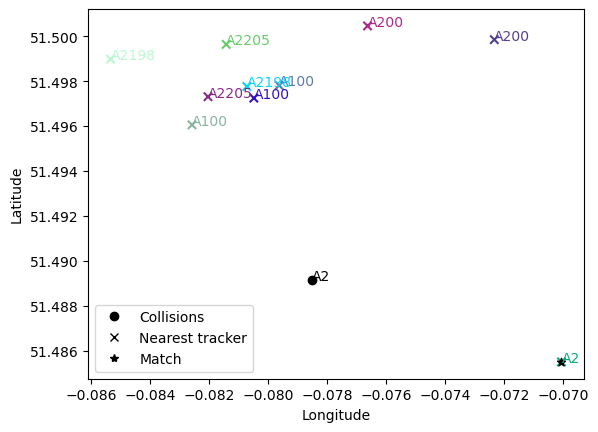

In [86]:
plotN = 100

colors = np.random.rand(10,3)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(collisions_year.iloc[match].iloc[plotN].Longitude,collisions_year.iloc[match].iloc[plotN].Latitude,c='black')
ax.annotate(road_classes[collisions_year.iloc[match].iloc[plotN]['1st_Road_Class']]+str(collisions_year.iloc[match].iloc[plotN]['1st_Road_Number']), (collisions_year.iloc[match].iloc[plotN].Longitude,collisions_year.iloc[match].iloc[plotN].Latitude),color='black')

ax.scatter(aadf_year.iloc[B[match][plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B[match][plotN].flatten().tolist()].Latitude.values,c=colors,marker='x')
for i,(txt,long,lat) in enumerate(zip(aadf_year.iloc[B[match][plotN].flatten().tolist()].Road_name.values,aadf_year.iloc[B[match][plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B[match][plotN].flatten().tolist()].Latitude.values)):
    ax.annotate(txt, (long,lat),color=colors[i])
    
print(check[match][plotN])

ax.scatter(aadf_year.iloc[B_match[plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B_match[plotN].flatten().tolist()].Latitude.values,c='black',marker='*')

#Get artists and labels for legend and chose which ones to display
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2)

#Create custom artists
simArtist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
anyArtist = plt.Line2D((0,1),(0,0), color='k',marker='x',linestyle='')
matchArtist = plt.Line2D((0,1),(0,0), color='k',marker='*',linestyle='')

#Create legend from custom artist/label lists
plt.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist,matchArtist],
          [label for i,label in enumerate(labels) if i in display]+['Collisions', 'Nearest tracker','Match'])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.xlim([-0.8,0.5])
#plt.ylim([51.2,51.8])
plt.show()

In [8]:
def get_file_contents(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)

In [9]:
api_key = get_file_contents('./Keys/google_maps.txt')

In [10]:
plotN = 700

colors = np.random.rand(plotN,3)

gmap = gmplot.GoogleMapPlotter(collisions_year.iloc[match].iloc[0].Latitude,collisions_year.iloc[match].iloc[0].Longitude,13,apikey=api_key)

gmap.scatter(collisions_year.iloc[match].head(plotN).Latitude,collisions_year.iloc[match].head(plotN).Longitude, color='red')
for i,(long,lat) in enumerate(zip(collisions_year.iloc[match].head(plotN).Longitude.values,collisions_year.iloc[match].head(plotN).Latitude.values)):
    road_name = road_classes[collisions_year.iloc[match].iloc[i]['1st_Road_Class']]+str(collisions_year.iloc[match].iloc[i]['1st_Road_Number'])
    gmap.text(lat,long,road_name,color='red')

gmap.scatter(aadf_year.iloc[B_match[:plotN].flatten().tolist()].Latitude.values,aadf_year.iloc[B_match[:plotN].flatten().tolist()].Longitude.values,c='blue')
for i,(txt,long,lat) in enumerate(zip(aadf_year.iloc[B_match[:plotN].flatten().tolist()].Road_name.values,aadf_year.iloc[B_match[:plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B_match[:plotN].flatten().tolist()].Latitude.values)):
    gmap.text(lat,long,txt,color='blue')

gmap.draw(r"C:\Users\tuthill.15\Documents\code-2022\Final Project\Plots\map2.html")

In [11]:
plotN = 0

gmap1 = gmplot.GoogleMapPlotter(collisions_year.iloc[match].iloc[plotN].Latitude,collisions_year.iloc[match].iloc[plotN].Longitude,13,apikey=api_key)

gmap1.marker(collisions_year.iloc[match].iloc[plotN].Latitude,collisions_year.iloc[match].iloc[plotN].Longitude, color='cornflowerblue')
road_name = road_classes[collisions_year.iloc[match].iloc[plotN]['1st_Road_Class']]+str(collisions_year.iloc[match].iloc[plotN]['1st_Road_Number'])
gmap1.text(collisions_year.iloc[match].iloc[plotN].Latitude,collisions_year.iloc[match].iloc[plotN].Longitude, text=road_name,color='cornflowerblue')

gmap1.scatter(aadf_year.iloc[B[match][plotN].flatten().tolist()].Latitude.values,aadf_year.iloc[B[match][plotN].flatten().tolist()].Longitude.values,c='red')
for i,(txt,long,lat) in enumerate(zip(aadf_year.iloc[B[match][plotN].flatten().tolist()].Road_name.values,aadf_year.iloc[B[match][plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B[match][plotN].flatten().tolist()].Latitude.values)):
    gmap1.text(lat,long,txt,color='red')


gmap1.draw(r"C:\Users\tuthill.15\Documents\code-2022\Final Project\Plots\map1.html")

## Examine 2nd road from collision

In [337]:
from sklearn.neighbors import NearestNeighbors

matches = 0
london_col = 0
too_fars = 0

k_neighbor = 10

for year in np.arange(2005,2019):
    
    #slice data on year and within Greater London
    aadf_year = aadf[(aadf.Year.dt.year == year) & (aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])].copy()
    collisions_year = collisions[(collisions.Date.dt.year == year) & (collisions.Longitude > corners[0][1]) & (collisions.Longitude < corners[1][1]) & (collisions.Latitude > corners[1][0]) & (collisions.Latitude < corners[0][0])].copy()
    
    #count collisions in London
    london_col += len(collisions_year)
    
    #find nearest aadf cp neighbor to collisions
    neigh = NearestNeighbors(n_neighbors=1,radius=1)
    neigh.fit(aadf_year[['Longitude','Latitude']])
    A,B = neigh.kneighbors(collisions_year[['Longitude','Latitude']],k_neighbor)
    
#     #count correct geomatches

    match_idx = np.zeros((len(B),k_neighbor))
    
    for i in range(k_neighbor):
        match_idx[aadf_year.iloc[B[:,i].flatten().tolist()].Road_name.values == collisions_year.Road_name.values,i] = 1
        
    invalid_val = -1
    mask = match_idx != 0
    check = np.where(mask.any(axis=1), mask.argmax(axis=1), invalid_val)
    
    match = np.where(check.astype(int) >= 0,True,False)
    
    A_match = A[np.arange(B.shape[0]),check][match]
    B_match = B[np.arange(B.shape[0]),check][match]
    
    Unlabeled = collisions_year[check == -1].Road_name.value_counts().loc[['U','C']].values.sum()/(check == -1).sum()
    
    print(year)
#     print('mean distance to CP:',A_match.mean()*61.8)
#     print('median distance to CP:',np.median(A_match)*61.8)
#     print('max distance to CP:',A_match.max()*61.8)
#     print('min distance to CP:',A_match.min()*61.8)
#     print('Correct geo match:',len(A_match))
#     print('Total London collisions:',len(collisions_year))
#     print('Unlabeled unmatched collisions:',Unlabeled)
#     print()
    
#     #for check idx = -1, look at 2nd labeled road in collision
    for i in range(k_neighbor):
        
        match2 = aadf_year.iloc[B[:,i].flatten().tolist()].Road_name.values == collisions_year.Road_name2.values
        match_idx[match2 & (check == -1),i] = 1
        
    invalid_val = -1
    mask = match_idx != 0
    check = np.where(mask.any(axis=1), mask.argmax(axis=1), invalid_val)
    
    match = np.where(check.astype(int) >= 0,True,False)
    
    matches += match.sum()
    
    A_match = A[np.arange(B.shape[0]),check][match]
    B_match = B[np.arange(B.shape[0]),check][match]
    
    Unlabeled = collisions_year[check == -1].Road_name.value_counts().loc[['U','C']].values.sum()/(check == -1).sum()
    
    dist = distance(collisions_year.iloc[match].Longitude.values,collisions_year.iloc[match].Latitude.values,aadf_year.iloc[B_match].Longitude.values,aadf_year.iloc[B_match].Latitude.values)*1.15078
    
    too_far = (dist <= aadf_year.iloc[B_match].Link_length_miles.values).sum()
    too_fars += too_far
    
    # print('2nd road added')
    print('mean distance to CP:',dist.mean())
    print('median distance to CP:',np.median(dist))
    print('max distance to CP:',dist.max())
    print('min distance to CP:',dist.min())
    print('Correct geo match:',match.sum())
    print('Correct geo match within tracker boundary:',too_far)
    print('Unlabeled unmatched collisions:',Unlabeled)
    print('Total London collisions:',len(collisions_year))
    print('% matched:',match.sum()/len(collisions_year))
    print('% matched in boundary:',too_far/len(collisions_year))
    
    print()
    print()
    print()

print('total')
print('Correct geo match:',matches)
print('Correct geo match within tracker boundary:',too_fars)
print('Total London collisions:',london_col)
print('% matched:',matches/london_col)
print('% matched in boundary:',too_fars/london_col)

2005
mean distance to CP: 0.18575259247699896
median distance to CP: 0.12018638173747181
max distance to CP: 1.283475514755317
min distance to CP: 0.0028655269873784864
Correct geo match: 837
Correct geo match within tracker boundary: 645
Unlabeled unmatched collisions: 0.6808510638297872
Total London collisions: 978
% matched: 0.8558282208588958
% matched in boundary: 0.6595092024539877



2006
mean distance to CP: 0.1821110856242771
median distance to CP: 0.11939196140479444
max distance to CP: 1.4394692759629069
min distance to CP: 0.0029452977992254297
Correct geo match: 917
Correct geo match within tracker boundary: 668
Unlabeled unmatched collisions: 0.631578947368421
Total London collisions: 1088
% matched: 0.8428308823529411
% matched in boundary: 0.6139705882352942



2007
mean distance to CP: 0.18216850561239764
median distance to CP: 0.11781302995697679
max distance to CP: 1.2986009116411665
min distance to CP: 0.002973938185355027
Correct geo match: 940
Correct geo match wi

-1


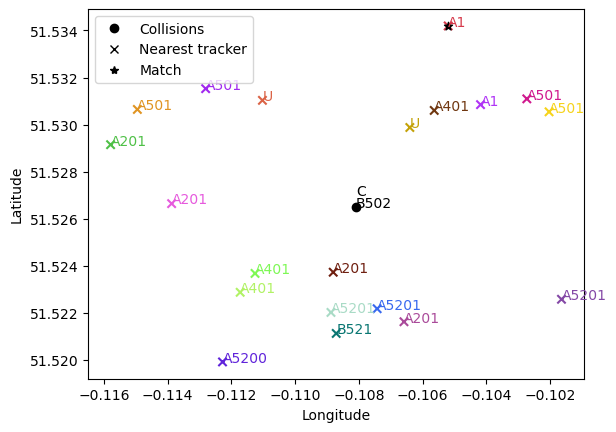

In [262]:
plotN = 32

colors = np.random.rand(20,3)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(collisions_year.iloc[plotN].Longitude,collisions_year.iloc[plotN].Latitude,c='black')
ax.annotate(collisions_year.iloc[plotN].Road_name, (collisions_year.iloc[plotN].Longitude,collisions_year.iloc[plotN].Latitude),color='black')
ax.annotate(collisions_year.iloc[plotN].Road_name2, (collisions_year.iloc[plotN].Longitude,collisions_year.iloc[plotN].Latitude+0.0005),color='black')

ax.scatter(aadf_year.iloc[B[plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B[plotN].flatten().tolist()].Latitude.values,c=colors,marker='x')
for i,(txt,long,lat) in enumerate(zip(aadf_year.iloc[B[plotN].flatten().tolist()].Road_name.values,aadf_year.iloc[B[plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B[plotN].flatten().tolist()].Latitude.values)):
    ax.annotate(txt, (long,lat),color=colors[i])
    
print(check[plotN])

ax.scatter(aadf_year.iloc[B[plotN,check[plotN]].flatten().tolist()].Longitude.values,aadf_year.iloc[B[plotN,check[plotN]].flatten().tolist()].Latitude.values,c='black',marker='*')

#Get artists and labels for legend and chose which ones to display
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2)

#Create custom artists
simArtist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
anyArtist = plt.Line2D((0,1),(0,0), color='k',marker='x',linestyle='')
matchArtist = plt.Line2D((0,1),(0,0), color='k',marker='*',linestyle='')

#Create legend from custom artist/label lists
plt.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist,matchArtist],
          [label for i,label in enumerate(labels) if i in display]+['Collisions', 'Nearest tracker','Match'])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.xlim([-0.8,0.5])
#plt.ylim([51.2,51.8])
plt.show()

In [258]:
np.where(check == -1)

(array([  25,   27,   32,   36,   42,   48,   53,   56,   61,   66,   78,
          81,   84,   86,   96,  102,  104,  111,  117,  147,  163,  164,
         179,  194,  216,  226,  254,  258,  263,  266,  269,  272,  290,
         301,  303,  326,  334,  336,  343,  349,  356,  367,  374,  376,
         379,  380,  389,  391,  401,  422,  423,  424,  435,  444,  446,
         448,  450,  453,  454,  471,  474,  477,  478,  488,  489,  492,
         510,  517,  521,  523,  527,  539,  549,  562,  569,  574,  575,
         581,  582,  583,  585,  588,  603,  610,  620,  635,  637,  644,
         656,  662,  678,  683,  691,  693,  706,  707,  714,  718,  719,
         726,  740,  741,  742,  743,  745,  756,  761,  781,  795,  809,
         816,  840,  841,  848,  863,  868,  869,  871,  878,  887,  908,
         928,  935,  938,  943,  946,  951,  957,  972,  994,  996, 1002,
        1003, 1013, 1017, 1020, 1022, 1036, 1038, 1040, 1041, 1042, 1044,
        1063, 1066, 1076, 1085, 1110, 

In [263]:
collisions_year[check == -1].Road_name.value_counts()

U        97
C        66
B134      5
B401      5
B402      4
B108      3
A11       3
B525      3
B204      3
A115      3
B515      2
B509      2
A13       2
B404      2
B310      2
B502      2
B305      2
B101      2
A20       2
B240      2
B410      2
B504      2
A3218     1
A1213     1
B135      1
A2201     1
B304      1
B100      1
A1204     1
B202      1
B118      1
B313      1
B164      1
B300      1
A2206     1
B214      1
B406      1
B319      1
A4201     1
B206      1
B122      1
A501      1
Name: Road_name, dtype: int64

In [252]:
aadf_year.iloc[B[check==-1,5].flatten().tolist()].Road_name.value_counts()

A40      20
A501     18
A3       16
U        16
A41      16
         ..
A3201     1
B521      1
A1208     1
A3214     1
A300      1
Name: Road_name, Length: 68, dtype: int64

## Work

In [338]:
(dist < aadf_year.iloc[B_match].Link_length_miles.values).sum()

1026

In [340]:
np.isnan(aadf_year.iloc[B_match].Link_length_km.values).sum()

254

In [334]:
aadf.columns

Index(['Count_point_id', 'Year', 'Region_id', 'Region_name', 'Region_ons_code',
       'Local_authority_id', 'Local_authority_name', 'Local_authority_code',
       'Road_name', 'Road_category', 'Road_type', 'Start_junction_road_name',
       'End_junction_road_name', 'Easting', 'Northing', 'Latitude',
       'Longitude', 'Link_length_km', 'Link_length_miles', 'Estimation_method',
       'Estimation_method_detailed', 'Pedal_cycles',
       'Two_wheeled_motor_vehicles', 'Cars_and_taxis', 'Buses_and_coaches',
       'LGVs', 'HGVs_2_rigid_axle', 'HGVs_3_rigid_axle',
       'HGVs_4_or_more_rigid_axle', 'HGVs_3_or_4_articulated_axle',
       'HGVs_5_articulated_axle', 'HGVs_6_articulated_axle', 'All_HGVs',
       'All_motor_vehicles'],
      dtype='object')

In [281]:
def distance(longitude1,latitude1,longitude2,latitude2):
    
    long1 = np.radians(longitude1)
    long2 = np.radians(longitude2)
    lati1 = np.radians(latitude1)
    lati2 = np.radians(latitude2)
    
    dlong = long2 - long1
    dlati = lati2 - lati1
    
    a = np.square(np.sin(dlati/2))+np.multiply(np.multiply(np.cos(lati1),np.cos(lati2)),np.square(np.sin(dlong/2)))
    c = 2 * np.arcsin(np.sqrt(a))
    
    r = 3955.082
    
    return c*r

In [117]:
fl = [name[0] for name in aadf.Road_name.values]

In [120]:
unique,counts = np.unique(fl,return_counts = True)
print(np.asarray((unique, counts)).T)

[['A' '372180']
 ['B' '24501']
 ['C' '29052']
 ['M' '22106']
 ['U' '63546']]


In [45]:
collisions['1st_Road_Class'].value_counts()

3    104757
6     91964
4     30886
5     23333
1        16
2         7
Name: 1st_Road_Class, dtype: int64

In [39]:
collisions['2nd_Road_Class'].value_counts()

 6    130121
-1     67697
 3     26293
 5     14644
 4     11679
 1       441
 2        88
Name: 2nd_Road_Class, dtype: int64

In [40]:
collisions['2nd_Road_Number'].value_counts()

 0       191348
-1         2474
 7201       637
 6          546
 4          535
          ...  
 8350         1
 7172         1
 7562         1
 8826         1
 8049         1
Name: 2nd_Road_Number, Length: 4903, dtype: int64

In [135]:
collisions.Road_name.value_counts()

U0       77721
C0        9471
A3        1767
A4        1701
A6        1497
         ...  
B6574        1
U879         1
B4533        1
B7006        1
U197         1
Name: Road_name, Length: 9404, dtype: int64

In [269]:
distance(collisions.iloc[match].Longitude.values,collisions.iloc[match].Latitude.values,aadf.iloc[B_match].Longitude.values,aadf.iloc[B_match].Latitude.values)*1.852

IndexError: Boolean index has wrong length: 978 instead of 250963

In [272]:
collisions.iloc[match].Longitude.values

IndexError: Boolean index has wrong length: 978 instead of 250963

In [210]:
match_idx[check==-1][aadf_year.iloc[B[check==-1,i].flatten().tolist()].Road_name.values == collisions_year.iloc[check==-1].Road_name2.values,i]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [180]:
match_idx[check==-1].shape

(499, 10)

In [187]:
(aadf_year.iloc[B[check=match_idx[check==-1][aadf_year.iloc[B[check==-1,i].flatten().tolist()].Road_name.values == collisions_year.iloc[check==-1].Road_name2.values,i] = 1=-1,i].flatten().tolist()].Road_name.values == collisions_year.iloc[check==-1].Road_name2.values).shape

(499,)

In [211]:
(check==-1).shape

(1698,)

In [212]:
match_idx.shape

(1698, 10)

In [215]:
for i in range(k_neighbor):

    match2 = aadf_year.iloc[B[:,i].flatten().tolist()].Road_name.values == collisions_year.Road_name2.values
    

In [216]:
match2.shape

(1698,)

In [217]:
match2

array([ True, False, False, ..., False, False, False])

In [228]:
np.where(match2 & (check == -1))

(array([  75,   88,  123,  134,  244,  425,  472,  504,  593,  626,  776,
         839,  891, 1073, 1234, 1315, 1389, 1545, 1648, 1691], dtype=int64),)

In [224]:
np.where(aadf_year.iloc[B[check==-1,i].flatten().tolist()].Road_name.values == collisions_year.iloc[check==-1].Road_name2.values)

(array([ 21,  28,  35,  37,  62, 112, 132, 139, 172, 179, 219, 233, 252,
        313, 354, 377, 396, 440, 477, 495], dtype=int64),)

In [233]:
np.where(match_idx[match2 & (check == -1)] == 0)

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19], dtype=int64),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
        2, 3, 4